In [1]:
import os
import pandas as pd

os.environ['TEJAPI_KEY'] = "your key"
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

In [2]:
from zipline.data import bundles
from zipline.api import *
from zipline.finance import commission, slippage
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from logbook import Logger, StderrHandler, INFO
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline

In [3]:
start = '2018-01-01'
end = '2023-12-31'
stock_list = ['00692', '00850', '00878', '00888', 'IR0001']
calendar_name = 'TEJ'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(stock_list)

!zipline ingest -b tquant

[2024-04-23 06:52:37.974720] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]   
Currently used TEJ API key call quota 9/100000 (0.01%)
Currently used TEJ API key data quota 14238/10000000 (0.14%)
[2024-04-23 06:52:43.534395] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [4]:
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.data import TWEquityPricing
bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

def make_pipeline():

    return Pipeline(
        columns = {
            "curr_price": TWEquityPricing.close.latest,
    },
        screen = ~StaticAssets([benchmark_asset])
    )
my_pipeline = run_pipeline(make_pipeline(), pd.Timestamp(start, tz='UTC'), pd.Timestamp(end, tz='UTC'))
my_pipeline

curr_price
2018-01-03 00:00:00+00:00 Equity(0 [00692])       21.01
2018-01-04 00:00:00+00:00 Equity(0 [00692])       21.15
2018-01-05 00:00:00+00:00 Equity(0 [00692])       21.27
2018-01-08 00:00:00+00:00 Equity(0 [00692])       21.30
2018-01-09 00:00:00+00:00 Equity(0 [00692])       21.42
...                                                 ...
2023-12-28 00:00:00+00:00 Equity(3 [00888])       14.49
2023-12-29 00:00:00+00:00 Equity(0 [00692])       32.63
                          Equity(1 [00850])       35.16
                          Equity(2 [00878])       21.77
                          Equity(3 [00888])       14.52

[4042 rows x 1 columns]

In [5]:
def initialize(context):
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))
    attach_pipeline(make_pipeline(), 'mystrats')

In [6]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrats')
    
    for asset in out_dir.index:
        stock_position = context.portfolio.positions[asset].amount
        if stock_position == 0:
            order_percent(asset, 0.25)

In [7]:
results = run_algorithm(
    start = pd.Timestamp(start, tz='UTC'),
    end = pd.Timestamp(end, tz ='UTC'),
    initialize=initialize,
    handle_data=handle_data,
    bundle='tquant',
    data_frequency='daily',
    capital_base=1e6,
    trading_calendar=get_calendar(calendar_name))

results

,period_open,period_close,positions,transactions,short_exposure,gross_leverage,net_leverage,pnl,starting_cash,ending_value,...,max_drawdown,algorithm_period_return,max_leverage,treasury_period_return,trading_days,period_label,algo_volatility,benchmark_period_return,excess_return,benchmark_volatility
2018-01-02 13:30:00+08:00,2018-01-02 09:01:00+08:00,2018-01-02 13:30:00+08:00,[],[],0.0,0.000000,0.000000,0.000000,1000000.000000,0.00,...,0.000000,0.000000,0.000000,0.0,1,2018-01,NaN,0.000000,0.000000,NaN
2018-01-03 13:30:00+08:00,2018-01-03 09:01:00+08:00,2018-01-03 13:30:00+08:00,[],[],0.0,0.000000,0.000000,0.000000,1000000.000000,0.00,...,0.000000,0.000000,0.000000,0.0,2,2018-01,0.000000,0.008481,-0.008481,NaN
2018-01-04 13:30:00+08:00,2018-01-04 09:01:00+08:00,2018-01-04 13:30:00+08:00,"[{'sid': Equity(0 [00692]), 'amount': 11820, '...","[{'amount': 11820, 'dt': 2018-01-04 13:30:00+0...",0.0,0.251503,0.251503,-362.498521,1000000.000000,251411.40,...,-0.000362,-0.000362,0.251503,0.0,3,2018-01,0.003322,0.012875,-0.013238,0.046297
2018-01-05 13:30:00+08:00,2018-01-05 09:01:00+08:00,2018-01-05 13:30:00+08:00,"[{'sid': Equity(0 [00692]), 'amount': 11820, '...",[],0.0,0.251768,0.251768,354.600000,748226.101479,251766.00,...,-0.000362,-0.000008,0.251768,0.0,4,2018-01,0.004648,0.015785,-0.015793,0.046130
2018-01-08 13:30:00+08:00,2018-01-08 09:01:00+08:00,2018-01-08 13:30:00+08:00,"[{'sid': Equity(0 [00692]), 'amount': 11820, '...",[],0.0,0.252828,0.252828,1418.400000,748226.101479,253184.40,...,-0.000362,0.001411,0.252828,0.0,5,2018-01,0.010857,0.019142,-0.017731,0.040668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,"[{'sid': Equity(0 [00692]), 'amount': 11820, '...",[],0.0,0.922598,0.922598,8544.700000,127788.040156,1523182.00,...,-0.270814,0.650970,1.066125,0.0,1459,2023-12,0.115768,1.067382,-0.416411,0.166363
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,"[{'sid': Equity(0 [00692]), 'amount': 11820, '...",[],0.0,0.923122,0.923122,11257.080000,127788.040156,1534439.08,...,-0.270814,0.662227,1.066125,0.0,1460,2023-12,0.115759,1.084639,-0.422412,0.166337
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,"[{'sid': Equity(0 [00692]), 'amount': 11820, '...",[],0.0,0.923889,0.923889,16732.960000,127788.040156,1551172.04,...,-0.270814,0.678960,1.066125,0.0,1461,2023-12,0.115789,1.101054,-0.422094,0.166308
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,"[{'sid': Equity(0 [00692]), 'amount': 11820, '...",[],0.0,0.923957,0.923957,1499.870000,127788.040156,1552671.91,...,-0.270814,0.680460,1.066125,0.0,1462,2023-12,0.115750,1.103269,-0.422809,0.166251


Start date,2018-01-02
End date,2023-12-29
Total months,69
,Backtest
Annual return,9.342%
Cumulative returns,67.946%
Annual volatility,11.571%
Sharpe ratio,0.83
Calmar ratio,0.34
Stability,0.80
Max drawdown,-27.081%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.08,2022-01-17,2022-10-25,2023-07-14,359
1,14.57,2020-01-14,2020-03-19,2020-07-08,114
2,11.98,2021-04-27,2021-05-17,2021-11-15,140
3,7.47,2023-07-28,2023-10-31,2023-12-14,96
4,4.76,2018-10-01,2018-12-26,2019-09-05,228


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.04%,-4.43%,4.30%


Top 10 long positions of all time,max
sid,
00850,30.07%
00692,29.67%
00888,26.11%
00878,24.62%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
00850,30.07%
00692,29.67%
00888,26.11%
00878,24.62%


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei


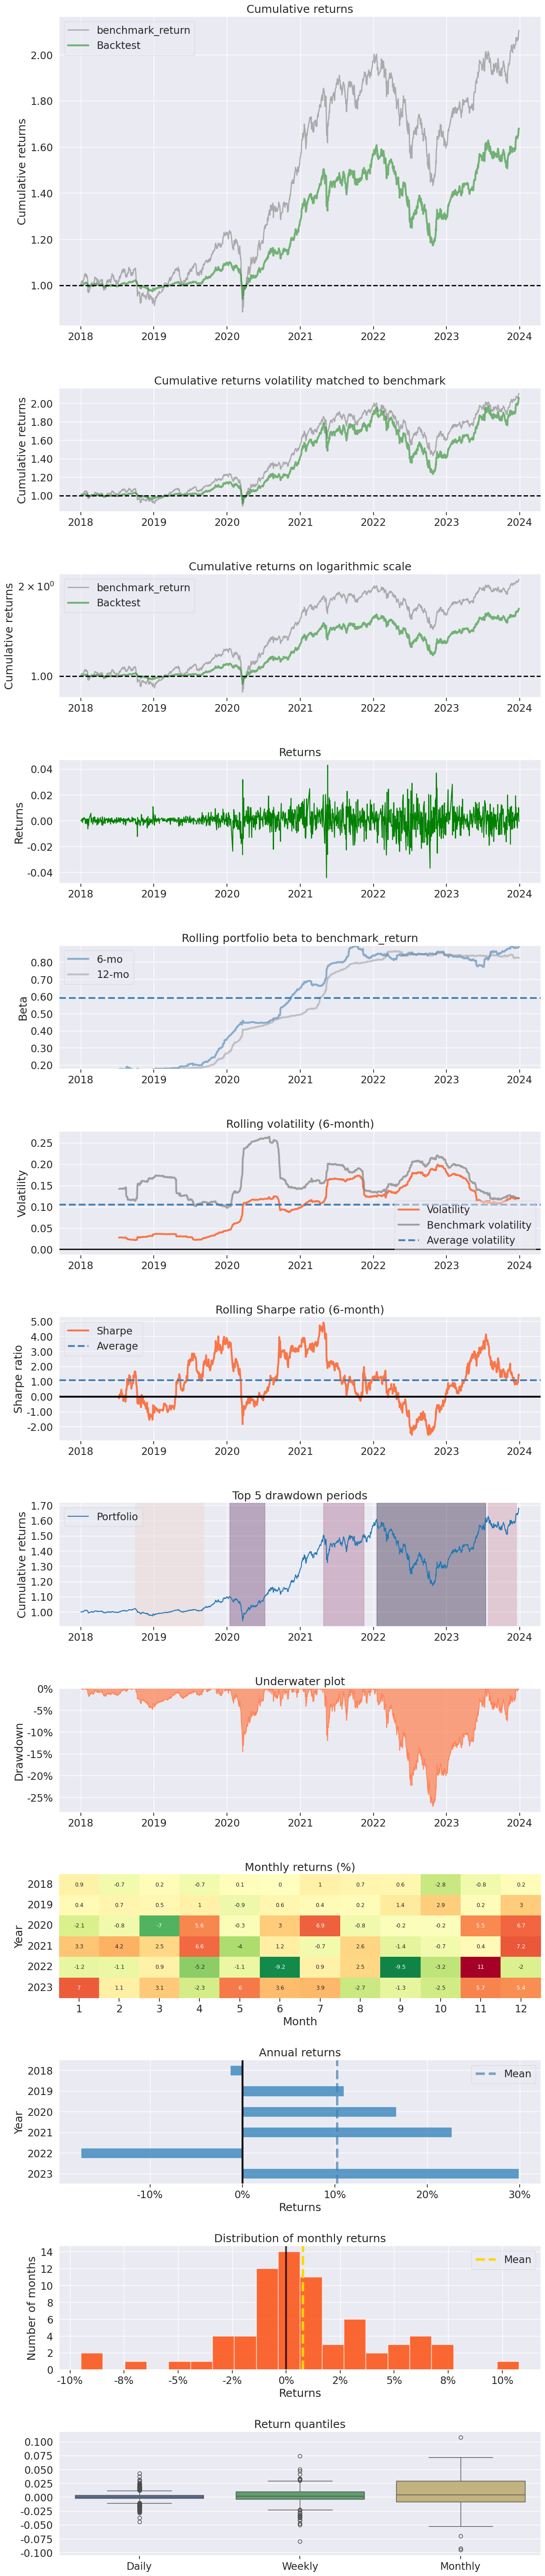

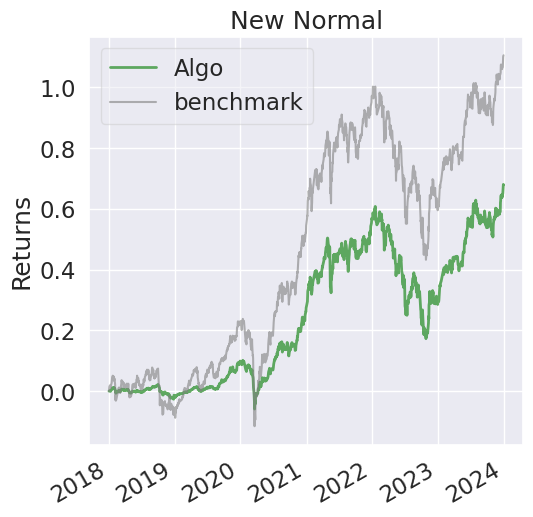

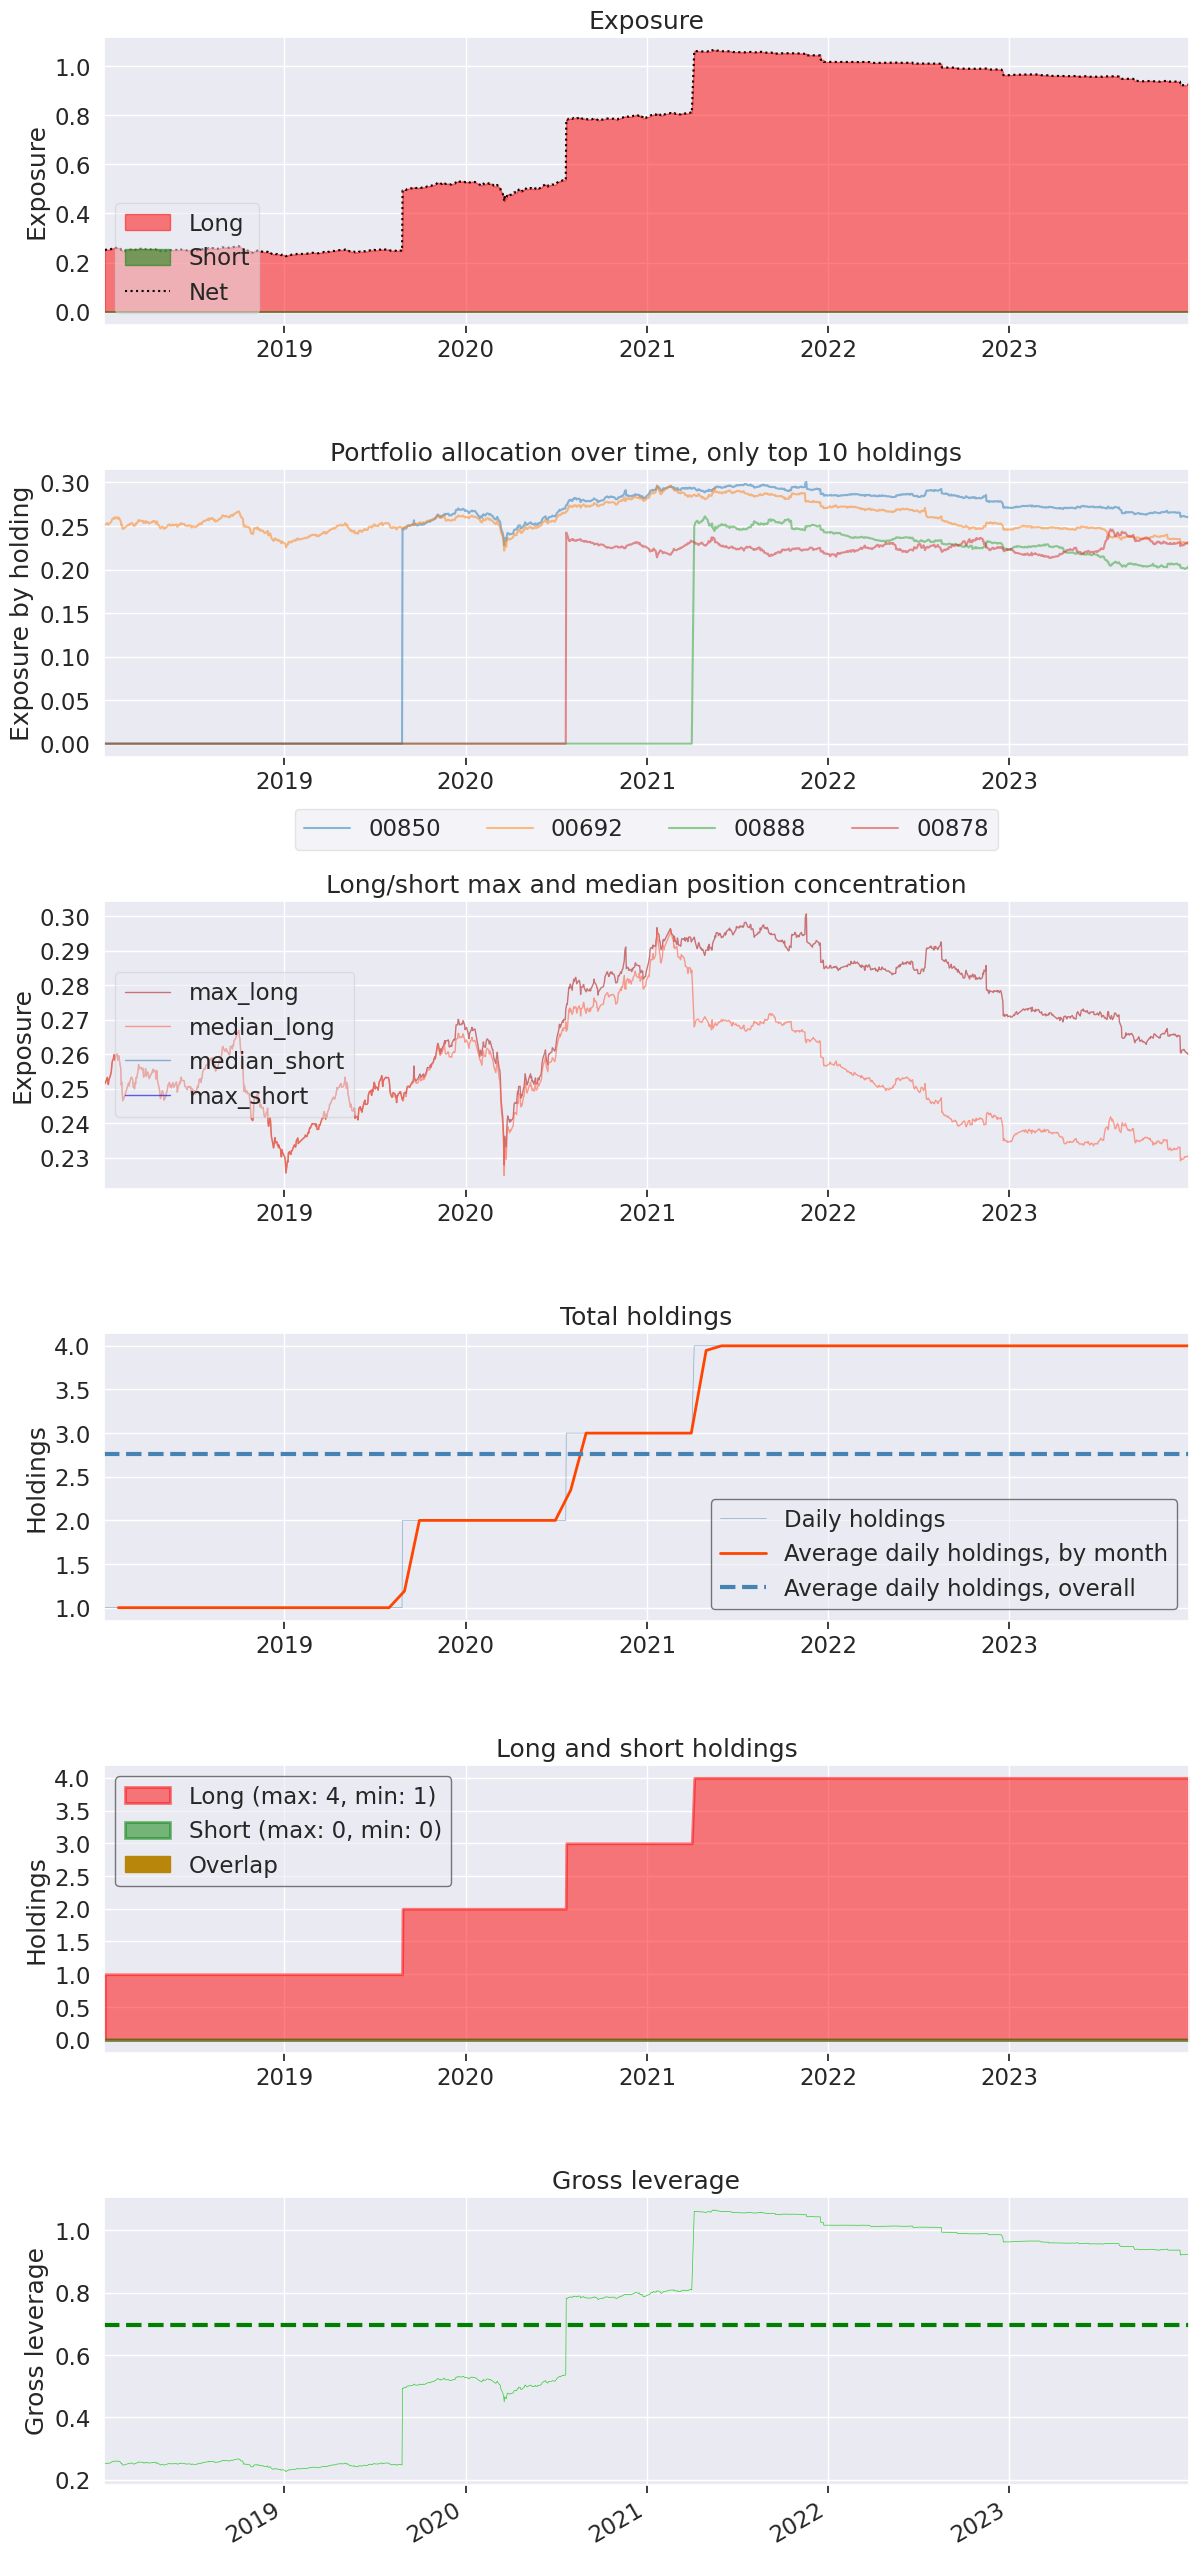

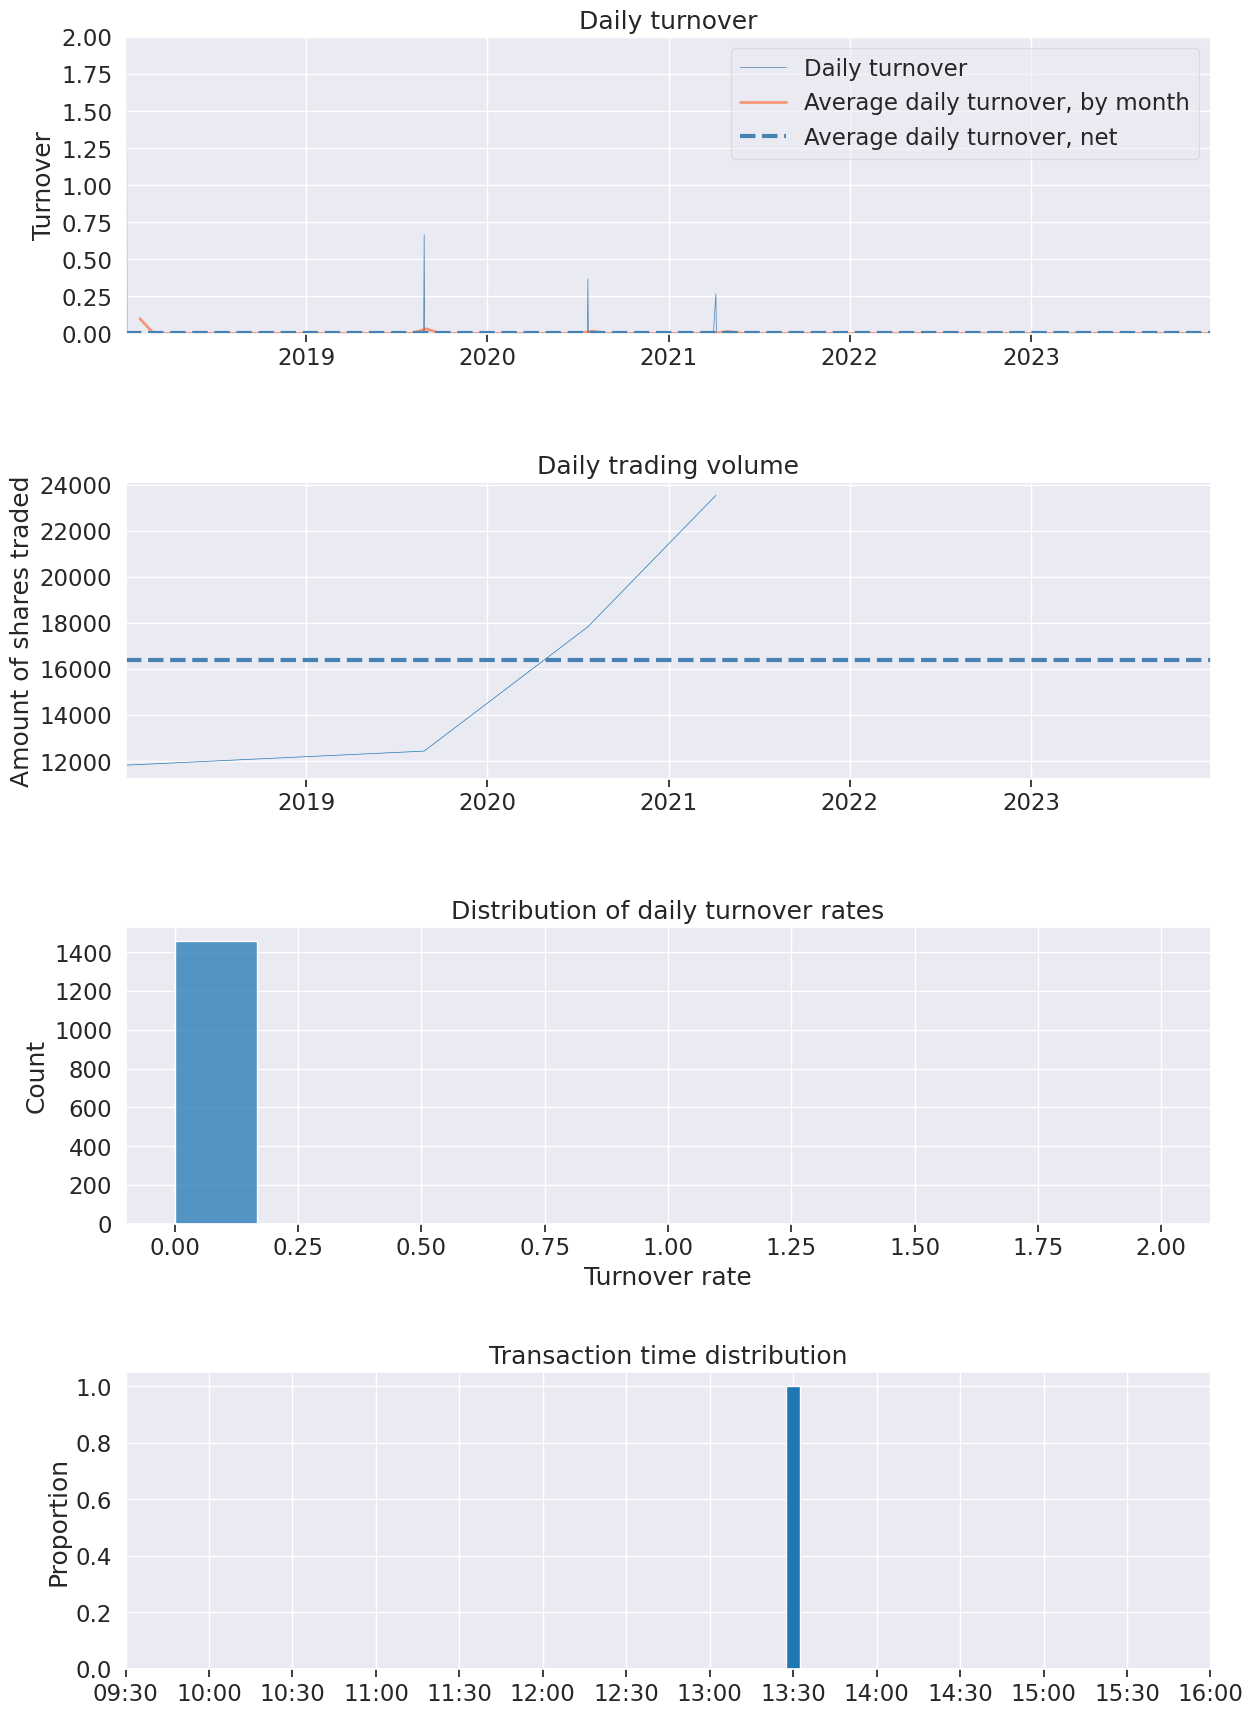

In [8]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions,
                            benchmark_rets = benchmark_rets,
                            round_trips=False)